<a href="https://colab.research.google.com/github/Faraz011/Assignment-AIML-Lab/blob/main/Dynamic_Pricing_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split



reading data form source file

In [10]:
data = pd.read_csv('data.csv')
print(data.head())

         date  year  month  day_of_week  day_of_month  week_of_year  quarter  \
0  2020-01-01  2020      1            3             1             1        1   
1  2020-01-01  2020      1            3             1             1        1   
2  2020-01-01  2020      1            3             1             1        1   
3  2020-01-02  2020      1            4             2             1        1   
4  2020-01-02  2020      1            4             2             1        1   

    day_name month_name  season  ...  price_difference price_advantage  \
0  Wednesday    January  Winter  ...             -0.04               1   
1  Wednesday    January  Winter  ...              0.52               0   
2  Wednesday    January  Winter  ...              1.27               0   
3   Thursday    January  Winter  ...             -0.71               1   
4   Thursday    January  Winter  ...             -0.75               1   

   price_ratio_vs_competitor starting_inventory  ending_inventory  restock

Data preprocessing and Feature Engineering

In [11]:
numeric_feat = data.select_dtypes(include = ['int64','float64']).columns


In [12]:
skewness = data[numeric_feat].skew()
print(skewness.sort_values(ascending = False))

demand_shock                 9.331092
is_holiday                   3.454220
stockout                     2.553046
demand                       2.196976
restocked                    2.127229
is_promotion                 2.023521
revenue                      1.536622
is_weekend                   0.951068
ending_inventory             0.863663
starting_inventory           0.810312
competitor_price             0.398402
own_price                    0.309400
price_ratio_vs_competitor    0.162447
year                         0.086362
price_advantage              0.056041
quarter                      0.031676
week_of_year                 0.026061
month                        0.017617
day_of_month                 0.014588
day_of_week                  0.000917
price_difference            -0.502031
dtype: float64


In [13]:
skewed_feat = skewness[abs(skewness) > 0.1].index
print(skewed_feat)

Index(['is_weekend', 'is_holiday', 'is_promotion', 'own_price',
       'competitor_price', 'price_difference', 'price_ratio_vs_competitor',
       'starting_inventory', 'ending_inventory', 'restocked', 'stockout',
       'demand', 'demand_shock', 'revenue'],
      dtype='object')


In [14]:
data['revenue'] = np.log1p(data['revenue'])
data['price_difference'] = np.log1p(data['price_difference'])

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
print (data['price_difference'].head())
print (data['revenue'].head())

0   -0.040822
1    0.418710
2    0.819780
3   -1.237874
4   -1.386294
Name: price_difference, dtype: float64
0    7.021111
1    7.380081
2    6.257342
3    6.911847
4    6.945764
Name: revenue, dtype: float64


In [16]:
data['price_x_promotion'] = data['own_price'] * data['is_promotion']
data['price_x_weekend'] = data['own_price'] * data['is_weekend']


print(data.head())

         date  year  month  day_of_week  day_of_month  week_of_year  quarter  \
0  2020-01-01  2020      1            3             1             1        1   
1  2020-01-01  2020      1            3             1             1        1   
2  2020-01-01  2020      1            3             1             1        1   
3  2020-01-02  2020      1            4             2             1        1   
4  2020-01-02  2020      1            4             2             1        1   

    day_name month_name  season  ...  price_ratio_vs_competitor  \
0  Wednesday    January  Winter  ...                   0.998822   
1  Wednesday    January  Winter  ...                   1.013815   
2  Wednesday    January  Winter  ...                   1.070477   
3   Thursday    January  Winter  ...                   0.975826   
4   Thursday    January  Winter  ...                   0.984349   

  starting_inventory  ending_inventory restocked  stockout  demand  \
0                500               467        

In [17]:
split_indx = int(len(data) * 0.8)
train_data = data[:split_indx]
test_data = data[split_indx:]

X_train = train_data[[
    'own_price', 'competitor_price', 'is_promotion','price_ratio_vs_competitor',
    'price_x_promotion', 'is_weekend', 'day_of_week', 'month', 'demand'
]]
y_train = train_data['revenue']
X_test = test_data[[
    'own_price', 'competitor_price', 'is_promotion', 'price_ratio_vs_competitor'
    ,'price_x_promotion', 'is_weekend', 'day_of_week', 'month', 'demand'
]]
y_test = test_data['revenue']

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = PoissonRegressor(alpha = 0.1,max_iter = 1000)
model.fit(X_train_scaled, y_train)

PoissonRegressor(alpha=0.1, max_iter=1000)

In [19]:
from sklearn.metrics import accuracy_score
predict = model.predict(X_test_scaled)


In [20]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predict)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.04949834214934195


In [21]:
mean = data['revenue'].mean()
print(f'Mean Revenue: {mean}')

Mean Revenue: 7.294554785652495


Implementing XGBoost

In [22]:
from xgboost import XGBRegressor, XGBClassifier

xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train, y_train)  # No scaling needed

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [23]:
!pip install xgboost

In [24]:
predict1 = xgb_model.predict(X_test)

In [25]:
mse1 = mean_squared_error(y_test, predict1)
print(f'Mean Squared Error: {mse1}')

Mean Squared Error: 0.0009311601629033063


In [26]:
rmse = np.sqrt(mse1)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.030514917055487898


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from xgboost import XGBRegressor, XGBClassifier


class PriceDemandPredictor:

    def __init__(self):
        self.price_model = None
        self.demand_model = None
        self.scaler_price = StandardScaler()
        self.scaler_demand = StandardScaler()

    def train_models(self, data):
        """Train both models on the same dataset"""

        # Clean data
        data = train_data.replace([np.inf, -np.inf], np.nan).dropna()

        # Numerical Encoding
        data['Product_num'] = pd.factorize(data['product_id'])[0]+1


        # Feature sets
        demand_features = data[['own_price','competitor_price','is_promotion','price_difference',
                                'price_x_promotion','is_weekend','day_of_week','month']]
        price_features = data[['competitor_price','is_promotion','price_difference','price_x_promotion',
                               'is_weekend','day_of_week','month','demand']]

        demand_target = data['demand']
        price_target = data['own_price']

        # Scale separately
        X_demand = self.scaler_demand.fit_transform(demand_features)
        X_price = self.scaler_price.fit_transform(price_features)

        # Train models
        self.price_model = PoissonRegressor(alpha=0.1, max_iter=1000)
        self.price_model.fit(X_price, price_target)

        self.demand_model = XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        self.demand_model.fit(X_demand, demand_target)

        print(" Models trained successfully on data.")
        return self

    def price_demand_prediction(self, data):
        """Predict new price and new demand on same dataset"""

        # Make a copy to avoid modifying original data
        data_copy = data.copy()
        data_copy = data_copy.replace([np.inf, -np.inf], np.nan).fillna(0)

        # --- Step 1: Predict new price ---
        price_features = data_copy[['competitor_price','is_promotion','price_difference','price_x_promotion',
                               'is_weekend','day_of_week','month','demand']]
        X_price = self.scaler_price.transform(price_features)
        new_price = self.price_model.predict(X_price)

        # temporarily add it
        data_copy['temp_price'] = new_price

        # --- Step 2: Predict new demand using new price ---
        # use temp_price as 'own_price' to match training feature names
        demand_features = data_copy[['temp_price','competitor_price','is_promotion','price_difference',
                                'price_x_promotion','is_weekend','day_of_week','month']].copy()
        demand_features = demand_features.rename(columns={'temp_price': 'own_price'})

        X_demand = self.scaler_demand.transform(demand_features)
        new_demand = self.demand_model.predict(X_demand)

        # --- Step 3: Create results DataFrame ---
        results = pd.DataFrame({
            'product_id': data['product_id'],
            'original_price': data['own_price'],
            'new_price': new_price,
            'original_demand': data['demand'],
            'new_demand': new_demand,
            'is_promotion': data['is_promotion'],

            'date': data['date'] if 'date' in data.columns else range(len(data))
        })

        print(" Predictions completed: ['new_price', 'new_demand']")
        return results




In [28]:
predictor = PriceDemandPredictor()
predictor.train_models(data)

 Models trained successfully on data.


In [29]:
results = predictor.price_demand_prediction(data)
price_pred = results['new_price']
demand_pred = results['new_demand']


print(f"Price predictions: {len(price_pred)} values")
print(f"Demand predictions: {len(demand_pred)} values")


print(results[['original_price', 'new_price', 'original_demand', 'new_demand']].head())


baseline_revenue = (results['original_price'] * results['original_demand']).sum()


optimized_revenue = (results['new_price'] * results['new_demand']).sum()

print("REVENUE COMPARISON:")
print(f"Baseline Revenue: ${baseline_revenue:,.2f}")
print(f"Optimized Revenue: ${optimized_revenue:,.2f}")


revenue_difference = optimized_revenue - baseline_revenue
uplift_percentage = (revenue_difference / baseline_revenue) * 100

print(f"Revenue Difference: ${revenue_difference:,.2f}")
print(f"Revenue Uplift: {uplift_percentage:.2f}%")


 Predictions completed: ['new_price', 'new_demand']
Price predictions: 4500 values
Demand predictions: 4500 values
   original_price  new_price  original_demand  new_demand
0           33.91  32.564545               33   33.127785
1           38.16  40.438644               42   45.255905
2           19.29  21.822536               27   40.053066
3           28.66  26.956029               35   56.013386
4           47.17  45.162490               22   30.964155
REVENUE COMPARISON:
Baseline Revenue: $7,317,044.55
Optimized Revenue: $9,436,117.34
Revenue Difference: $2,119,072.79
Revenue Uplift: 28.96%


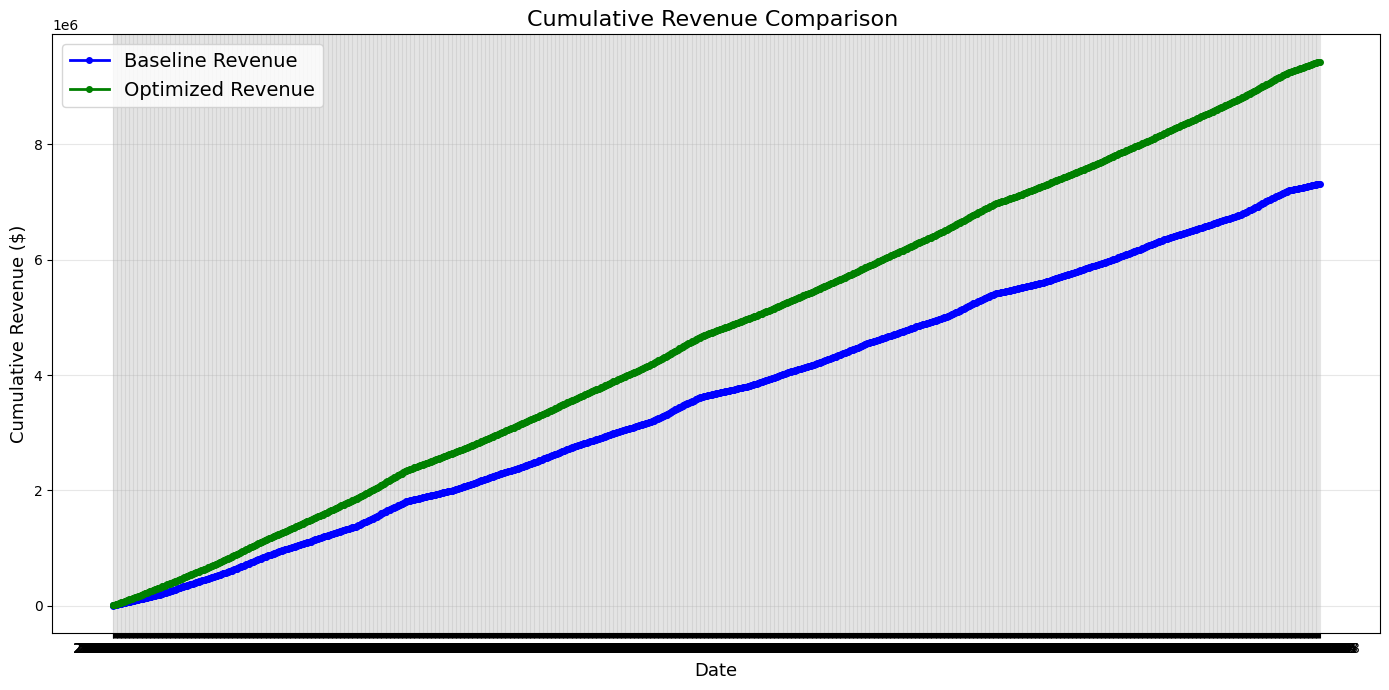

In [30]:
import matplotlib.pyplot as plt

# Make sure columns exist
if 'baseline_revenue' not in results.columns or 'optimized_revenue' not in results.columns:
    results['baseline_revenue'] = results['original_price'] * results['original_demand']
    results['optimized_revenue'] = results['new_price'] * results['new_demand']

# Sort by date
results_sorted = results.sort_values(['date'])

# Sum by date
revenue_by_date = results_sorted.groupby('date')[['baseline_revenue', 'optimized_revenue']].sum().reset_index()

# Cumulative revenue plot
revenue_by_date['cumulative_baseline'] = revenue_by_date['baseline_revenue'].cumsum()
revenue_by_date['cumulative_optimized'] = revenue_by_date['optimized_revenue'].cumsum()

plt.figure(figsize=(14, 7))
plt.plot(revenue_by_date['date'], revenue_by_date['cumulative_baseline'], label='Baseline Revenue', color='blue', linewidth=2, marker='o', markersize=4)
plt.plot(revenue_by_date['date'], revenue_by_date['cumulative_optimized'], label='Optimized Revenue', color='green', linewidth=2, marker='o', markersize=4)

plt.title('Cumulative Revenue Comparison ', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Cumulative Revenue ($)', fontsize=13)
plt.legend(loc='upper left', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()


plt.show()


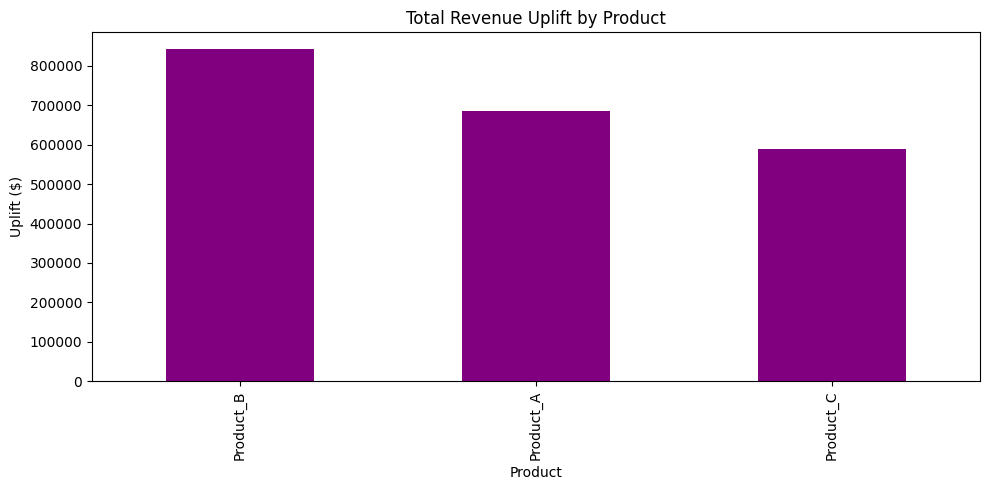

In [31]:
uplift_by_product = results.groupby('product_id')[['baseline_revenue','optimized_revenue']].sum()
uplift_by_product['uplift'] = uplift_by_product['optimized_revenue'] - uplift_by_product['baseline_revenue']

uplift_by_product['uplift_pct'] = (uplift_by_product['uplift'] / uplift_by_product['baseline_revenue'] * 100).round(1)
uplift_by_product = uplift_by_product.sort_values('uplift', ascending=False)

uplift_by_product['uplift'].plot(kind='bar', color='purple', figsize=(10,5))
plt.title('Total Revenue Uplift by Product')
plt.xlabel('Product')
plt.ylabel('Uplift ($)')
plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

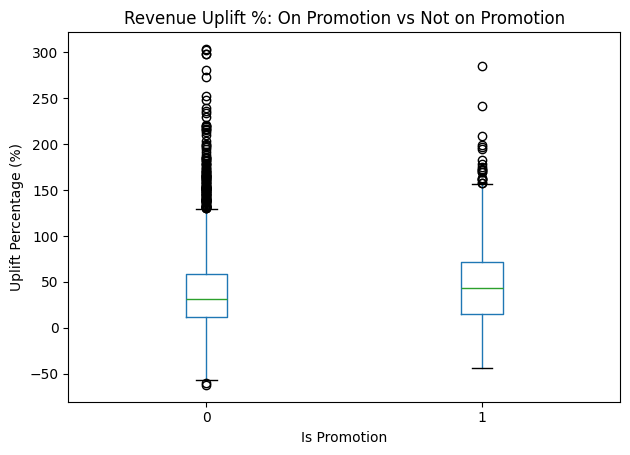

In [32]:
results['uplift_pct'] = (results['optimized_revenue'] - results['baseline_revenue']) / results['baseline_revenue'] * 100

plt.figure(figsize=(8,5))
results.boxplot(column='uplift_pct', by='is_promotion', grid=False)
plt.title('Revenue Uplift %: On Promotion vs Not on Promotion')
plt.suptitle('')
plt.xlabel('Is Promotion')
plt.ylabel('Uplift Percentage (%)')
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

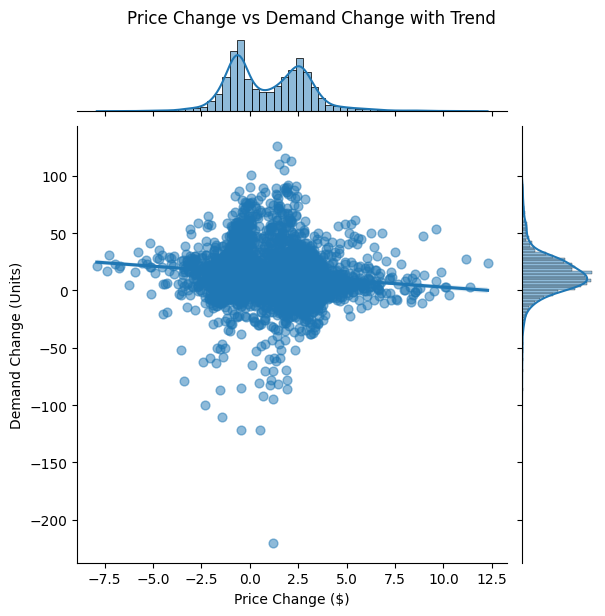

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.jointplot(
    x=results['new_price'] - results['original_price'],
    y=results['new_demand'] - results['original_demand'],
    kind='reg',
    height=6,
    scatter_kws={'alpha': 0.5, 's': 40}
)
plt.xlabel('Price Change ($)')
plt.ylabel('Demand Change (Units)')

plt.suptitle("Price Change vs Demand Change with Trend", y=1.02)
plt.show()


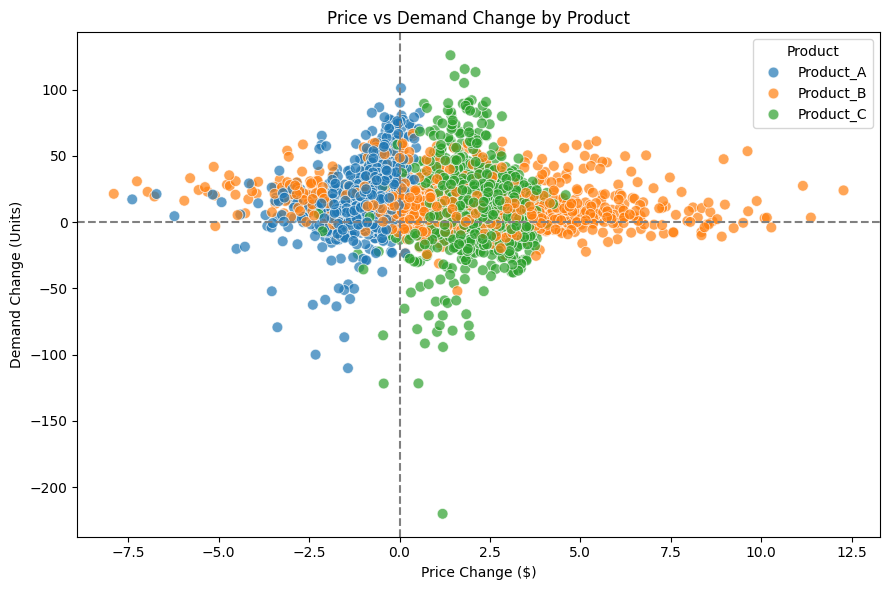

In [34]:
plt.figure(figsize=(9,6))
sns.scatterplot(
    x=results['new_price'] - results['original_price'],
    y=results['new_demand'] - results['original_demand'],
    hue=results['product_id'], alpha=0.7, s=60
)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Price vs Demand Change by Product')
plt.xlabel('Price Change ($)')
plt.ylabel('Demand Change (Units)')
plt.legend(title='Product')
plt.tight_layout()
plt.show()


Forecasting : Using Prophet with lags features

In [35]:
import pandas as pd
import numpy as np
from prophet import Prophet

def make_lag_rolling_features(df, target_col='y', lags=(1,7,14), roll_windows=(3,7,14)):
    """
    Add lag and rolling features to a DataFrame sorted by ds.
    """
    df = df.copy().sort_values('ds').reset_index(drop=True)

    # Lag features
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    # Rolling stats (shifted to avoid leakage)
    for w in roll_windows:
        df[f'roll_mean_{w}'] = df[target_col].rolling(window=w, min_periods=1).mean().shift(1)
        df[f'roll_std_{w}'] = df[target_col].rolling(window=w, min_periods=1).std().shift(1)
        df[f'roll_min_{w}'] = df[target_col].rolling(window=w, min_periods=1).min().shift(1)
        df[f'roll_max_{w}'] = df[target_col].rolling(window=w, min_periods=1).max().shift(1)

    return df

def forecast_with_static_regressors(model, df, periods=30, freq='D', regressors=None):
    """
    Forecast using Prophet with static regressors
    """
    future = model.make_future_dataframe(periods=periods, freq=freq)

    if regressors:

        for r in regressors:
            if r in df.columns:
                last_val = df[r].iloc[-1]
                future[r] = last_val

    forecast = model.predict(future)
    return forecast


print("PROPHET WITH LAGS/ROLLING FEATURES - CORRECTED")
print("=" * 50)


if 'date' in data.columns:
    data = data.rename(columns={'date': 'ds'})

featured_data = make_lag_rolling_features(data, target_col='demand', lags=(1,7,14), roll_windows=(3,7,14))


featured_data = featured_data.rename(columns={'demand': 'y'})


business_regressors = [
    'own_price',
    'competitor_price',
    'is_promotion',
    'is_holiday',

    'day_of_week'
]

lag_rolling_regressors = [
    'lag_1', 'lag_7', 'lag_14',
    'roll_mean_3', 'roll_mean_7', 'roll_mean_14',
    'roll_std_3', 'roll_std_7', 'roll_std_14'
]

# Combine all regressors
all_regressors = business_regressors + lag_rolling_regressors

# Filter regressors that actually exist in the data
available_regressors = [r for r in all_regressors if r in featured_data.columns]

print(f"Available regressors: {len(available_regressors)}")
print(f"Regressors: {available_regressors}")


model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10
)

# Add each regressor to the model
for regressor in available_regressors:
    model.add_regressor(regressor)
    print(f"Added regressor: {regressor}")

training_columns = ['ds', 'y'] + available_regressors
training_data = featured_data[training_columns].dropna()

print(f"\nTraining data shape: {training_data.shape}")
print(f"Date range: {training_data['ds'].min()} to {training_data['ds'].max()}")


print("\nTraining Prophet model...")
model.fit(training_data)
print("Model training completed!")


print("\n Generating forecasts...")
forecast = forecast_with_static_regressors(
    model=model,
    df=training_data,
    periods=30,
    freq='D',
    regressors=available_regressors
)

print("Forecasting completed!")


print(f"\nFORECAST RESULTS:")
future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)
print(future_forecast.head(10))

print(f"\nForecast summary:")
print(f"• Average predicted demand: {future_forecast['yhat'].mean():.2f}")
print(f"• Prediction range: {future_forecast['yhat'].min():.2f} - {future_forecast['yhat'].max():.2f}")
print(f"• Confidence interval width: {(future_forecast['yhat_upper'] - future_forecast['yhat_lower']).mean():.2f}")


PROPHET WITH LAGS/ROLLING FEATURES - CORRECTED
Available regressors: 14
Regressors: ['own_price', 'competitor_price', 'is_promotion', 'is_holiday', 'day_of_week', 'lag_1', 'lag_7', 'lag_14', 'roll_mean_3', 'roll_mean_7', 'roll_mean_14', 'roll_std_3', 'roll_std_7', 'roll_std_14']


DEBUG:cmdstanpy:input tempfile: /tmp/tmpf3vgqymw/tx03fjgh.json


Added regressor: own_price
Added regressor: competitor_price
Added regressor: is_promotion
Added regressor: is_holiday
Added regressor: day_of_week
Added regressor: lag_1
Added regressor: lag_7
Added regressor: lag_14
Added regressor: roll_mean_3
Added regressor: roll_mean_7
Added regressor: roll_mean_14
Added regressor: roll_std_3
Added regressor: roll_std_7
Added regressor: roll_std_14

Training data shape: (4486, 16)
Date range: 2020-01-05 to 2024-02-08

Training Prophet model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpf3vgqymw/h6yjt_47.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53677', 'data', 'file=/tmp/tmpf3vgqymw/tx03fjgh.json', 'init=/tmp/tmpf3vgqymw/h6yjt_47.json', 'output', 'file=/tmp/tmpf3vgqymw/prophet_model_m8362hg/prophet_model-20251009041846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:18:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:18:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model training completed!

 Generating forecasts...
Forecasting completed!

FORECAST RESULTS:
             ds       yhat  yhat_lower  yhat_upper
1496 2024-02-09  42.235046   19.297224   64.777903
1497 2024-02-10  66.694077   43.023176   90.654083
1498 2024-02-11  54.653321   28.906393   78.438246
1499 2024-02-12  56.897119   32.295803   80.910274
1500 2024-02-13  43.889161   19.608978   66.394492
1501 2024-02-14  36.269283   12.678974   59.989471
1502 2024-02-15  36.886803   12.090681   60.094002
1503 2024-02-16  41.087075   18.669260   66.410382
1504 2024-02-17  66.304301   42.943997   88.738518
1505 2024-02-18  55.104205   31.726001   77.224392

Forecast summary:
• Average predicted demand: 56.51
• Prediction range: 36.27 - 87.91
• Confidence interval width: 47.64


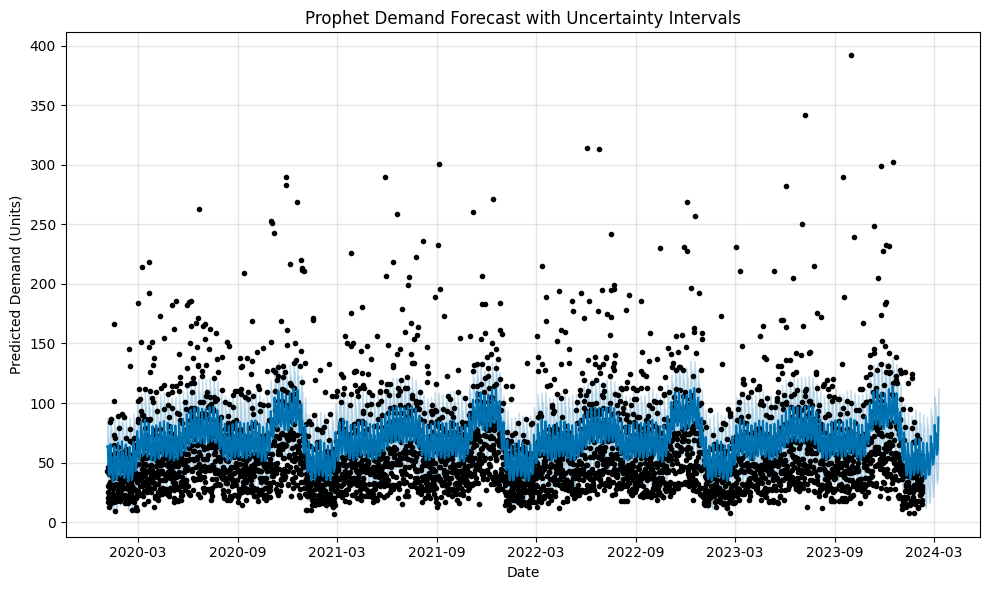

In [36]:
import matplotlib.pyplot as plt

fig = model.plot(forecast)
plt.title('Prophet Demand Forecast with Uncertainty Intervals')
plt.xlabel('Date')
plt.ylabel('Predicted Demand (Units)')
plt.tight_layout()
plt.show()


Pricing Policy : Rule base and Conceptual bandits using Thompson sampling

In [37]:
import numpy as np
import pandas as pd
from typing import Dict, List

class PricingConfig:
    """Configuration for pricing constraints"""

    def __init__(self, cost_price: float, min_margin_pct: float = 15.0, max_price_multiplier: float = 2.0):
        self.cost_price = cost_price
        self.min_margin_pct = min_margin_pct
        self.max_price_multiplier = max_price_multiplier

        self.min_price = cost_price * (1 + min_margin_pct / 100)
        self.max_price = cost_price * max_price_multiplier

    def get_available_prices(self, price_steps: int = 10) -> List[float]:
        prices = np.linspace(self.min_price, self.max_price, price_steps)
        return [round(p, 2) for p in prices]



In [38]:
class RuleBasedPricer:
    """Rule-based pricing with business logic"""

    def __init__(self, config: PricingConfig):
        self.config = config
        self.pricing_rules = {
            'competitive_match_threshold': 0.95,
            'high_inventory_discount': 0.90,
            'low_inventory_premium': 1.10,
            'inventory_high_threshold': 80,
            'inventory_low_threshold': 30,
            'high_demand_premium': 1.15,
            'low_demand_discount': 0.85,
            'demand_high_threshold': 60,
            'demand_low_threshold': 30,
            'peak_season_premium': 1.20,
            'off_season_discount': 0.90
        }

    def predict_price(self, context: Dict) -> float:
        base_price = self.config.min_price
        competitor_price = context.get('competitor_price', base_price)
        competitive_price = competitor_price * self.pricing_rules['competitive_match_threshold']

        # Inventory adjustment
        inventory_level = context.get('inventory_level', 50)
        if inventory_level > self.pricing_rules['inventory_high_threshold']:
            inventory_factor = self.pricing_rules['high_inventory_discount']
        elif inventory_level < self.pricing_rules['inventory_low_threshold']:
            inventory_factor = self.pricing_rules['low_inventory_premium']
        else:
            inventory_factor = 1.0

        # Demand adjustment
        recent_demand = context.get('recent_demand', 45)
        if recent_demand > self.pricing_rules['demand_high_threshold']:
            demand_factor = self.pricing_rules['high_demand_premium']
        elif recent_demand < self.pricing_rules['demand_low_threshold']:
            demand_factor = self.pricing_rules['low_demand_discount']
        else:
            demand_factor = 1.0

        # Seasonal adjustment
        is_peak_season = context.get('is_peak_season', False)
        seasonal_factor = (self.pricing_rules['peak_season_premium'] if is_peak_season
                          else self.pricing_rules['off_season_discount'])

        # Combine rules
        rule_price = max(base_price, competitive_price) * inventory_factor * demand_factor * seasonal_factor
        final_price = max(self.config.min_price, min(rule_price, self.config.max_price))

        # Find closest available price
        available_prices = self.config.get_available_prices()
        return min(available_prices, key=lambda x: abs(x - final_price))

In [42]:
config = PricingConfig(cost_price=14.2)


predictor = RuleBasedPricer(config)

def row_to_context(row):
  return {
      'competitor_price': row['competitor_price'], # Corrected column name
      'inventory_level': row.get('ending_inventory', 50), # Using ending_inventory as inventory level
      'recent_demand': row['demand'], # Using demand as recent demand

      }

data['recommended_price'] = data.apply(lambda row: predictor.predict_price(row_to_context(row)), axis=1)
print(data[['competitor_price', 'ending_inventory', 'demand', 'recommended_price']].head()) # Changed df to data and included relevant columns

   competitor_price  ending_inventory  demand  recommended_price
0             33.95               467      33              25.72
1             37.64               258      42              28.40
2             18.02               773      27              16.33
3             29.37               432      35              23.04
4             47.92               236      22              28.40


Contextual Bandit

In [ ]:
class ThompsonSamplingPricer:
    """Thompson Sampling for pricing to maximize Revenue = Price × Demand"""

    def __init__(self, config: PricingConfig, n_features: int = 5):
        self.config = config
        self.n_features = n_features
        self.alpha = 0.1
        self.lambda_reg = 1.0
        self.price_models = {}
        self.revenue_history = []

    def _context_to_vector(self, context: Dict) -> np.ndarray:
        return np.array([
            context.get('competitor_price', 28.0) / 40.0,
            context.get('inventory_level', 50) / 100.0,
            context.get('recent_demand', 45) / 100.0,
            float(context.get('is_peak_season', False)),
            context.get('day_of_week', 3) / 7.0
        ])

    def _get_or_create_model(self, price: float) -> Dict:
        if price not in self.price_models:
            self.price_models[price] = {
                'S': self.lambda_reg * np.eye(self.n_features),
                'b': np.zeros(self.n_features),
                'mu': np.zeros(self.n_features),
                'n_observations': 0,
                'total_revenue': 0.0,
                'avg_demand': 0.0
            }
        return self.price_models[price]

    def predict_price(self, context: Dict) -> float:
        x = self._context_to_vector(context)
        available_prices = self.config.get_available_prices()

        best_price = available_prices[0]
        best_sampled_revenue = -np.inf

        for price in available_prices:
            model = self._get_or_create_model(price)

            try:
                S_inv = np.linalg.inv(model['S'])
                model['mu'] = S_inv @ model['b']
                theta_sample = np.random.multivariate_normal(model['mu'], self.alpha**2 * S_inv)
            except (np.linalg.LinAlgError, ValueError):
                theta_sample = model['mu'] + np.random.normal(0, self.alpha, self.n_features)

            sampled_revenue = x.T @ theta_sample

            if sampled_revenue > best_sampled_revenue:
                best_sampled_revenue = sampled_revenue
                best_price = price

        return best_price

    def update_model(self, context: Dict, price: float, actual_demand: float):
        x = self._context_to_vector(context)
        revenue = price * actual_demand

        model = self._get_or_create_model(price)
        model['S'] += np.outer(x, x) / (self.alpha**2)
        model['b'] += revenue * x / (self.alpha**2)
        model['n_observations'] += 1
        model['total_revenue'] += revenue
        model['avg_demand'] += (actual_demand - model['avg_demand']) / model['n_observations']

        self.revenue_history.append(revenue)

    def get_model_performance(self) -> Dict:
        if not self.revenue_history:
            return {"total_observations": 0}

        recent_window = min(20, len(self.revenue_history))
        return {
            'total_observations': len(self.revenue_history),
            'total_revenue': sum(self.revenue_history),
            'avg_revenue': np.mean(self.revenue_history),
            'recent_avg_revenue': np.mean(self.revenue_history[-recent_window:]),
            'price_models_learned': len(self.price_models)
        }

predictor = ThompsonSamplingPricer(config)



